In [206]:
import emcee

In [207]:
import fsps

In [208]:
import corner

In [209]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Problem 1

The error on Wikipedia is that it suggests Miller and Scalo (1979) found $\alpha = 0$ where $\xi(m) = \xi_o e^{-\alpha}$; however, they are in log space so they really said $\alpha = 0$ where $\xi(\log m) = \xi_o e^{-\alpha}$. It's also worth noting that Miller and Scalo only like that value at 0.1 $M_{\odot}$ and prefer a value of 0.4 in the mass range $0.1 - 1 M_{\odot}$ which Wikipedia does not make clear.

# Problem 2

## 2.1

In [210]:
#theta = (Mmin,Mmax,alpha)
theta_true = [3.0,15.0,2.35]
N = 1000 #number of stars to generate
dm = 0.01 #distance between mass bins in model

def powerLaw(M,theta):
    return M**(-theta[2])

def probDist(dm,theta):
    '''Normalized probability distribution of masses'''
    arr = np.arange(theta[0],theta[1],dm)
    prob = powerLaw(arr, theta)
    return arr,prob/np.sum(prob)

def sample_dist(N,dm,theta):
    arr, pd = probDist(dm,theta)
    stars = np.random.choice(arr,N,p=pd) #non-uniform random sample over the mass range, where pd is the prob. distribution
    return stars


In [211]:
stars = sample_dist(N,dm,theta_true)
logstars = np.log10(stars)

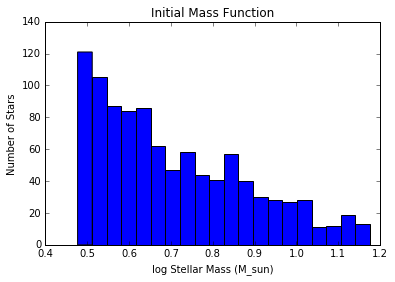

In [212]:
plt.hist(logstars,bins=20)
plt.title('Initial Mass Function')
plt.xlabel('log Stellar Mass (M_sun)')
plt.ylabel('Number of Stars')
plt.show()
    

## 2.2

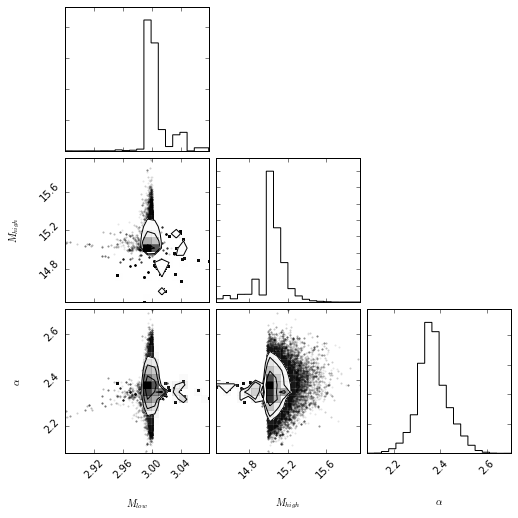

In [213]:
ndim, nwalkers = 3, 100

def lnlike(theta,stars):
    '''Integrated c analytically and took log
    theta = [mmin,mmax,alpha]'''
    mmin = theta[0]
    mmax = theta[1]
    alpha = theta[2]
    c = (1-alpha) / (mmax**(1-alpha) - mmin**(1-alpha))
    lnlk = np.sum(np.log(c) - alpha*np.log(stars))
    return lnlk

def lnprior(theta,stars):
    '''Flat prior for now.'''
    if 0.05 < theta[0] < np.min(stars) and np.max(stars) < theta[1] < 100.0 and 1.0 < theta[2] < 5.0:
        return 0.0
    else:
        return -np.inf
    
def lnprob(theta,stars):
    if np.isfinite(lnprior(theta,stars)):
        return lnprior(theta,stars) + lnlike(theta,stars)
    else:
        return -np.inf

thetaguess = np.asarray([3,15,2.35])
def p0gen(thetaguess):
    '''Takes in a guess at params, makes tiny ball of walkers around it
    ensuring distance between walkers in each dimension is proportional
    to the characteristic size scale'''
    return np.add(np.multiply(1e-2*np.random.randn(len(thetaguess)),thetaguess),thetaguess)

#randomize initial position of walkers
p0 = [p0gen(thetaguess) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[stars])
sampler.run_mcmc(p0, 1000)

fig = corner.corner(sampler.flatchain, labels=['$M_{low}$', '$M_{high}$',r'$\alpha$'])
plt.show()


## 2.3

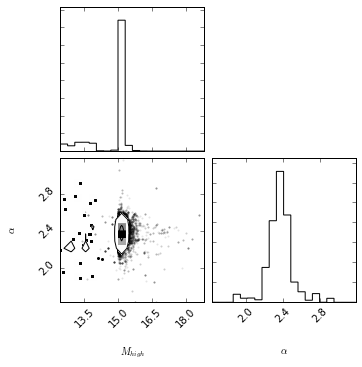

In [214]:
#theta = [mmax,alpha]
ndim, nwalkers = 2, 100

def lnlike(theta,stars):
    '''Integrated c analytically and took log
    Now theta = [mmax,alpha]'''
    mmin = 3.0
    mmax = theta[0]
    alpha = theta[1]
    c = (1-alpha) / (mmax**(1-alpha) - mmin**(1-alpha))
    lnlk = np.sum(np.log(c) - alpha*np.log(stars))
    return lnlk

def lnprior(theta,stars):
    '''Flat prior for now.'''
    if np.max(stars) < theta[0] < 100.0 and 1.0 < theta[1] < 5.0:
        return 0.0
    else:
        return -np.inf
    
def lnprob(theta,stars):
    if np.isfinite(lnprior(theta,stars)):
        return lnprior(theta,stars) + lnlike(theta,stars)
    else:
        return -np.inf

thetaguess = np.asarray([15.0,2.35])
def p0gen(thetaguess):
    '''Takes in a guess at params, makes tiny ball of walkers around it
    ensuring distance between walkers in each dimension is proportional
    to the characteristic size scale'''
    return np.add(np.multiply(1e-1*np.random.randn(len(thetaguess)),thetaguess),thetaguess)

#randomize initial position of walkers
p0 = [p0gen(thetaguess) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[stars])
sampler.run_mcmc(p0, 1000)

fig = corner.corner(sampler.flatchain, labels=['$M_{high}$',r'$\alpha$'])
plt.show()

## 2.4

In [215]:
#generate some more fake data:
alpha_list, sigalpha_list = [],[]
Nlist = [4,10,100,1000,10000]
for Nstars in Nlist:
    print(Nstars)
    stars = sample_dist(Nstars,dm,theta_true)
    
    #and run it through the sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[stars])
    sampler.run_mcmc(p0, 1000)
    
    cutchain = sampler.chain[:,100:,:]
    chainMmax = cutchain[:,:,0].flatten()
    chainalpha = cutchain[:,:,1].flatten()
    
    alpha, sigalpha = np.mean(chainalpha), np.mean(np.abs(chainalpha-np.mean(chainalpha)))
    alpha_list.append(alpha)
    sigalpha_list.append(sigalpha)

4
10
100
1000
10000


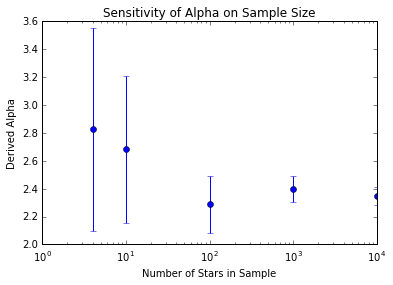

In [216]:
plt.errorbar(Nlist,alpha_list,yerr=sigalpha_list,linestyle='None',marker='o')
plt.xscale('log')
plt.title('Sensitivity of Alpha on Sample Size')
plt.xlabel('Number of Stars in Sample')
plt.ylabel('Derived Alpha')
plt.show()

# Problem 3

Best fit parameters are -alpha = -1.40746599117 +/- 0.0734354982408 and const = 0.0360849713895 +/- 0.00248354374109


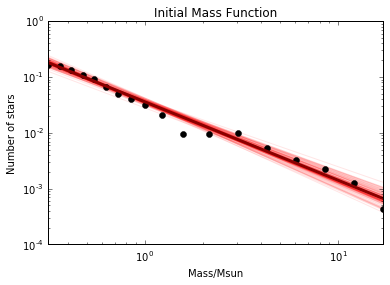

In [217]:
import scipy.optimize
'''actually log m/msun + 1 and log imf + 10'''
logm = np.asarray([2.23,2.08,1.93,1.78,1.63,1.48,1.33,1.20,1.09,1.00,0.93,0.86,0.80,0.74,0.68,0.62,0.56,0.50])
logimf = np.asarray([6.63,7.10,7.36,7.52,7.72,8.00,7.98,7.98,8.32,8.50,8.60,8.70,8.83,8.97,9.04,9.13,9.20,9.22])

def func(m,alpha,const):
    '''simple power law'''
    return const*m**alpha

m = 10.0**(logm - 1)
imf = 10.0**(logimf - 10)

'''Do the optimization with curve_fit for the power law'''
guess = [-2.0,0.1]
fit,cov = scipy.optimize.curve_fit(func,m,imf,p0=guess)

alpha,const = fit[0],fit[1]
alphaerr, consterr = np.sqrt(np.diag(cov))

print('Best fit parameters are -alpha = '+str(alpha)+' +/- '+str(alphaerr)+' and const = '+str(const)+' +/- '+str(consterr))


fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale("log")
ax.set_yscale("log")

for j in range(100):
    ax.plot(m,func(m,alpha+alphaerr*np.random.randn(),const+consterr*np.random.randn()),linewidth='1',color='r',alpha=0.1)
ax.plot(m,imf,linestyle = 'None', marker='o',color='k')
ax.plot(m,func(m,alpha,const),linewidth=3,color='darkred')
ax.set_xlim([m[-1],m[0]])
ax.set_ylabel('Number of stars')
ax.set_xlabel('Mass/Msun')
ax.set_title('Initial Mass Function')
plt.show()


We got alpha = 1.41, while Salpeter got 1.35.  That's a difference of (1.41-1.35)/1.35 = 0.044. That's within 5%, but I'd still trust the modern techniques. We got constant of 0.036, where Salpeter just has 0.03 with no more significant digits - that makes it hard to tell how far off it actually is from what we got

## Now using emcee

In [218]:
#Need to set this up like parameter estimation from the last homework.

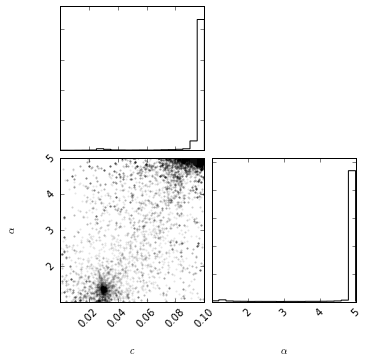

In [219]:
# theta = [c, alpha, sigma]
ndim, nwalkers = 2, 100

def model(m,c,alpha):
    return c*m**(-alpha)

def lnlike(theta,m,imf):
    ''''''
    c = theta[0]
    alpha = theta[1]
    diff = np.sqrt((imf - model(m,c,alpha))**2) #we can't really use a Gaussian here bc we don't know the errors... how to deal with that?
    return np.sum(diff)

def lnprior(theta):
    if 0.0 < theta[0] < 0.1 and 1.0 < theta[1] < 5.0:
        return 0.0
    else:
        return -np.inf
    
def lnprob(theta,m,imf):
    return lnprior(theta) + lnlike(theta,m,imf)

thetaguess = np.asarray([0.03,1.35])
def p0gen(thetaguess):
    '''Takes in a guess at params, makes tiny ball of walkers around it
    ensuring distance between walkers in each dimension is proportional
    to the characteristic size scale'''
    return np.add(np.multiply(1e-2*np.random.randn(len(thetaguess)),thetaguess),thetaguess)

#randomize initial position of walkers
p0 = [p0gen(thetaguess) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[m,imf])
sampler.run_mcmc(p0, 1000)

fig = corner.corner(sampler.flatchain, labels=['$c$',r'$\alpha$'])
plt.show()


This is wrong, but I'm not sure what to do to fix it. Somehow I should have included a Gaussian but there are no error bars on it... how should this be approached?  Somehow it seems to have found $c = 0.03$ and $\alpha = 1.35$ but it likes to maximize both $c$ and $\alpha$ instead better. This remains true if I decrease the size of my top-hat prior to be a narrower range around the ''true'' values

# Problem 4

## Part A

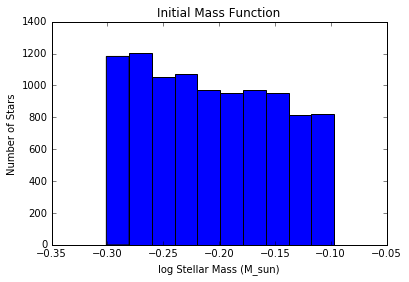

In [220]:
#theta = (Mmin,Mmax,alpha)
theta_true = [0.5,0.8,2.35]
N = 10000 #number of stars to generate
dm = 0.001 #distance between mass bins in model

def chabrier(M,theta):
    return (0.15/M)*np.exp(-(np.log10(M) - np.log10(0.08))**2/(2*0.69**2))

def probDist(dm,theta):
    '''Normalized probability distribution of masses'''
    arr = np.arange(theta[0],theta[1],dm)
    prob = chabrier(arr, theta)
    return arr,prob/np.sum(prob)

def sample_dist(N,dm,theta):
    arr, pd = probDist(dm,theta)
    stars = np.random.choice(arr,N,p=pd) #non-uniform random sample over the mass range, where pd is the prob. distribution
    return stars

stars = sample_dist(N,dm,theta_true)
logstars = np.log10(stars)

plt.hist(logstars,bins=10)
plt.title('Initial Mass Function')
plt.xlabel('log Stellar Mass (M_sun)')
plt.ylabel('Number of Stars')
plt.show()

## Part B

In [221]:
#theta = [alpha]

ndim, nwalkers = 1, 100

def lnlike(theta,stars):
    '''Integrated c analytically and took log
    Now theta = [mmax,alpha]'''
    mmin = 0.5
    mmax = 0.8
    alpha = theta[0]
    c = (1-alpha) / (mmax**(1-alpha) - mmin**(1-alpha))
    lnlk = np.sum(np.log(c) - alpha*np.log(stars))
    return lnlk

def lnprior(theta,stars):
    '''Flat prior for now.'''
    if 1.0 < theta[0] < 5.0:
        return 0.0
    else:
        return -np.inf
    
def lnprob(theta,stars):
    if np.isfinite(lnprior(theta,stars)):
        return lnprior(theta,stars) + lnlike(theta,stars)
    else:
        return -np.inf

thetaguess = np.asarray([2.35])
def p0gen(thetaguess):
    '''Takes in a guess at params, makes tiny ball of walkers around it
    ensuring distance between walkers in each dimension is proportional
    to the characteristic size scale'''
    return np.add(np.multiply(1e-1*np.random.randn(len(thetaguess)),thetaguess),thetaguess)

#randomize initial position of walkers
p0 = [p0gen(thetaguess) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[stars])
sampler.run_mcmc(p0, 1000)

(array([[ 1.87377639],
        [ 1.80367525],
        [ 1.67329081],
        [ 1.83264311],
        [ 1.8815296 ],
        [ 1.85265389],
        [ 1.81643634],
        [ 1.79938012],
        [ 1.8522815 ],
        [ 1.87606301],
        [ 1.92357989],
        [ 1.92722775],
        [ 1.84977668],
        [ 1.88483065],
        [ 2.01093005],
        [ 1.88248416],
        [ 1.89119328],
        [ 1.9113548 ],
        [ 1.94807561],
        [ 1.83213   ],
        [ 1.98424307],
        [ 1.86098334],
        [ 1.78099116],
        [ 1.79341502],
        [ 1.76920139],
        [ 1.7688048 ],
        [ 1.74750225],
        [ 1.93455795],
        [ 1.88250686],
        [ 1.6406696 ],
        [ 1.98097276],
        [ 1.81443701],
        [ 1.80015058],
        [ 1.87313152],
        [ 1.84624567],
        [ 1.92683167],
        [ 1.8424068 ],
        [ 1.87838576],
        [ 1.80597906],
        [ 1.94064387],
        [ 1.9945931 ],
        [ 1.87392866],
        [ 1.80776931],
        [ 1

Mean alpha value = 1.86546759461 +/- 0.0598306435357


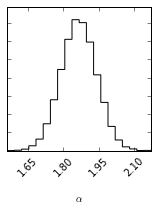

In [222]:
cutchain = sampler.chain[:,100:,:]
chainalpha = cutchain[:,:,0].flatten()

print('Mean alpha value = '+str(np.mean(chainalpha))+' +/- '+str(np.mean(np.abs(chainalpha-np.mean(chainalpha)))))

fig = corner.corner(chainalpha, labels=[r'$\alpha$']) #flatchain -> chainalpha
plt.show()

Kroupa's value was alpha = 2.2 in this mass range. We have (1.84 - 2.2)/2.2 = -0.16, i.e. the Chabrier value is ~16% different.

# Problem 5

## 5.1

In [223]:
age = 0.01 #Gyr
alpha = [0.8,1.3,1.8]

sp = fsps.StellarPopulation(compute_vega_mags=False, sfh=0, imf_type=2, imf3=alpha[0]+1, tage=age, sf_start=13.7)
wave, spec = sp.get_spectrum(tage=13.7+age) #already in angstroms

sp.params['imf3'] = alpha[1]+1
wave1, spec1 = sp.get_spectrum(tage=13.7+age)

sp.params['imf3'] = alpha[2]+1
wave2, spec2 = sp.get_spectrum(tage=13.7+age)

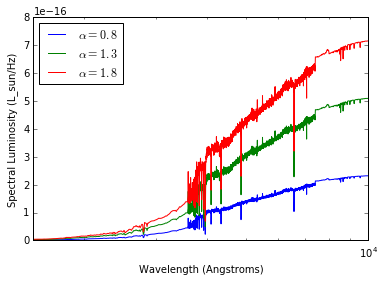

In [224]:
low, = plt.semilogx(wave,spec)
med, = plt.semilogx(wave1,spec1)
high, = plt.semilogx(wave2,spec2)
plt.legend([low,med,high],[r'$\alpha = 0.8$',r'$\alpha = 1.3$',r'$\alpha = 1.8$'],loc='upper left')
plt.xlim([1500,10000])
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Spectral Luminosity (L_sun/Hz)')
plt.show()

## 5.2

In [225]:
age = 10.0 #Gyr
imf_type = [0,2,3]

sp = fsps.StellarPopulation(compute_vega_mags=False, sfh=0, imf_type=imf_type[0], tage=age, sf_start=3.7)
wave, spec = sp.get_spectrum(tage=13.7) #already in angstroms

sp.params['imf_type'] = imf_type[1]
wave1, spec1 = sp.get_spectrum(tage=13.7)

sp.params['imf_type'] = imf_type[2]
wave2, spec2 = sp.get_spectrum(tage=13.7)

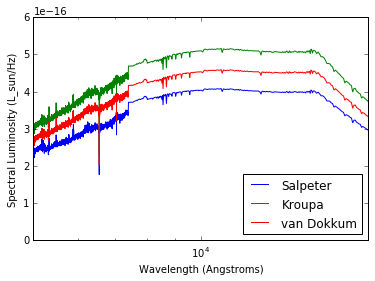

In [226]:
low, = plt.semilogx(wave,spec)
med, = plt.semilogx(wave1,spec1)
high, = plt.semilogx(wave2,spec2)
plt.legend([low,med,high],['Salpeter','Kroupa','van Dokkum'],loc='lower right')
plt.xlim([5000,20000])
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Spectral Luminosity (L_sun/Hz)')
plt.show()